# Python tabanlı enerji depolama simulasyonu ve Türkiye elektrik sistemine etkisinin incelemesi

Barış Sanlı (barissanli2@gmail.com)


### Giriş

Bu çalışmanın ana sorusu: Enerji depolama sistemlerinin Türkiye elektrik sistemini nasıl etkileyebileceğidir. Python üzerinde çalıştırılan bir kod ile 2018 yılı Türkiye elektrik talep verileri kullanılarak enerji depolamanın muhtemel etkisi incelenmiştir. Model çok kısa olduğundan sadece fikir vermek amaçlanmıştır. Yoksa gerçek veya karar almak için kullanılamaz. Yapılan çalışma tamamen hobi amaçlıdır.

Çalışmada kullanılan 
* Excel dosyası (http://barissanli.com/python/2018-elektrik.xlsx) 
* Program kodları da (https://github.com/barissanli/python-energy/ ) 

adresinden indirilebilir.

#### Excel dosyası

Linkte verilen excel dosyasında 2018 yılı elektrik sisteminde üretilen lisanslı ve lisanssız tüm üretim ve fiyat rakamları vardır. Verilerin kaynağı EPİAŞ'tır. Excel dosyasında iki tane alt sayfa var. Biri **"2018-saatlik"** ve diğeri de **"2018-gunluk"**. Bu yazıda saatlik verileri kullanacağız. 

#### Program kodları

Python'da yazılan kodları çalıştırabilen Jupyter defter dosyası **github** dan erişilebilir. 

**UYARI: Depolama algoritması her parametrede stabil değil, bunu en altta teknik kısımda anlatıyorum**

### Başlangıç
Önce programımızda kullanacağımız kütüphaneleri yüklüyoruz. Ben Jupyter'de doğrudan aşağıdaki iki satırı kullanarak, kütüphaneleri daha az kod ile yüklemeyi tercih ediyorum

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Şimdi de Excel dosyasındaki 2018 yılı saatlik verilerini **prices** değişkenine yükleyelim. Excel dosyasındaki değişkenler Türkçe. Kodda İngilizce kısımlar ise uluslararası paylaşım sağlamak içindir.

In [2]:
prices=pd.read_excel("2018-elektrik.xlsx",sheet_name="2018-saatlik")


## Depolama Benzeticisi(Simülatörü)

Depolama benzeticisi toplam bir elektrik depolama hacmi (Örneğin 1000 MWh) ve bu depolama hacminin(**storage_amount**) şarj ve deşarj edilme sürelerini belirleyen **storage_time** değişkeninden oluşur. Yani şarj süresi 4 saat ise, önümüzdeki 24 saatte 4 saat şarj, 4 saat deşarj şeklinde toplam 4000 MWh'lik bir pil kapasitesi kullanıyor demektir.

Kod 24 saatlik dilimlere bakıyor. Bu 24 saatlik dilimlerde en düşük talep saatlerinde kendini şarj ederek talebi yükseltiyor, en yüksek talep dönemlerinde ise şarj ettiği elektriği geri veriyor.

 Aslında çok daha basit bir kod ile başladım. 
    
### İlk depolama simulatörü

İlk depolama simülatörü görüldüğü üzere çok basit bir koddan oluşuyordu. Satır satır
* Değişkenleri değer olarak *sort24* e aktarıyor
* Şarj ile gelmesi gereken noktayı hesaplıyor *storage_up2* yu hesaplıyor
* Bu gelmesi gereken noktaya kadar en düşük talebi olan saatlerde depolama yapıyor
* Deşarj olacağı noktayı hesaplıyor *storage_discharge*
* Bu seviyeye kadar depolama ile sistem talebini karşılıyor

In [3]:
def storage_player(df,storage_amount=1000, storage_time=4):
    sorted24=pd.DataFrame(df.values).sort_values(by=0,ascending=True)
    storage_up2=(sorted24[0:storage_time].mean().values+(storage_amount/storage_time))[0]
    sorted24["storage"]=0
    # first charge
    for i in range(0,storage_time): 
        sorted24.iloc[i,1]=storage_up2-sorted24.iloc[i,0]
    
    storage_discharge=(sorted24[-storage_time:].mean().values-(storage_amount/storage_time))[0]
    # then discharge
    for i in range(-storage_time,0): 
        sorted24.iloc[i,1]=storage_discharge-sorted24.iloc[i,0]
    unsorted=sorted24.sort_index()
    unsorted["after-storage"]=unsorted[0]+unsorted["storage"]
        
    return unsorted;

### Çalışan benzetici

Yukarıdaki kodda piller şarj olmadan, sisteme elektrik verme durumları yaşadım. Ayrıca Python'un doğasından dolayı verilerin birbirine kopyalanırken sadece değer değil referansların da taşınması sorunu ile, herşeyi baştan ve test ederek yazmak zorunda kaldım. Çok daha karışık oldu ama stabilitesi nisbeten daha iyi.

Bu kod 24 saatlik dilimler halinde

* En düşük ve en yüksek tüketimleri sıralıyor  <br>
    *Ör* sorted24=pd.DataFrame(df.values).sort_values(by=0,ascending=True)

* En düşük ve en yüksek tüketimlerin birbirinin içine girmediğinden emin olmaya çalışıyor (Yani gece piller boş iken sisteme elektrik vermiyor) <br>
    *Ör* while max(indextmp[0:storage_time])>min(indextmp[-storage_time:]):

* Sonra en düşük talep dönemlerinin ortalamasının üzerine ortalama depolama miktarı (1000 MWh/4 saat = 250 MWh) ekleyerek şarj seviyesi buluyor <br>
    *Ör* storage_up2=(original.iloc[minvalues].mean().values[0]+(storage_amount/storage_time))
    
* Elektrik sistemi zor bir sistem, bu sebeple arkasından kodun doğru çalıştığını kontrol eden bir iki algoritma daha çalışıyor. Bunlar:
    * Önce şarj sonra deşarj olduğundan(sadece 1 defa test ediyor, normalde storage_time kadar test etse iyi olur),
    * Miktarların aşılmadığından
    emin olmaya yarıyor.
    
Kod karışık gelebilir. Eğer tek parametre girilecek ise sadece 24 saatlik talep verisi (pandas.DataFrame) olarak girilmesi yeterlidir. Fonksiyon otomatik olarak depolama miktarını 4000 MWh ve şarj-deşarj sürelerini 4 saat olarak alacaktır.  


In [4]:
def storage_player(df,storage_amount=4000, storage_time=4):
    # depolama süresini arttırdıkça stabilite sorun yaşıyor
    # if storage_time>7: storage_time=6
    original=pd.DataFrame(df.values)
     
    #en düşük talepten en yüksek talebe doğru sırala
    sorted24=pd.DataFrame(df.values).sort_values(by=0,ascending=True)
    #sıralamayı bir değişkene al
    indextmp=sorted24.index.values    
    syc=0  # 3 defa sorun görünce çık, sayacı şimdi sıfırla
    # eğer en düşük talep saatlerinden biri en yüksek talep saatlerinden birinden yüksek değerde ise, sorun var demektir. 
    # Şarj olmadan deşarj oluyor demektir. Bunu engellemek için aşağıdaki kod yazıldı
    # bu aykırı saatleri en düşük ve en yüksek talep değerleri içinden siliyor
    while max(indextmp[0:storage_time])>min(indextmp[-storage_time:]):
        if max(indextmp[0:storage_time])> average(indextmp[-storage_time:]): 
            maxdeger=max(indextmp[0:storage_time])
            tmp=[]
            for i in range(0,len(indextmp)):
                if indextmp[i]==maxdeger:
                    ;
                else:
                    tmp.append(indextmp[i]);
            indextmp=tmp
        if min(indextmp[-storage_time:])< average(indextmp[0:storage_time]): 
            mindeger=min(indextmp[-storage_time:])
            tmp=[]
            for i in range(0,len(indextmp)):
                if indextmp[i]==mindeger:
                    ;
                else:
                    tmp.append(indextmp[i]);
            indextmp=tmp
        syc=syc+1
        if syc>3: break; # 3 defa sorunda çık
    
    minvalues=indextmp[0:storage_time]  # en düşük talep saatleri
    maxvalues=indextmp[-storage_time:]  # en yüksek talep saatleri
    #print(minvalues,"- -",maxvalues)
    
    unsorted=sorted24.sort_index()
    storage_up2=(original.iloc[minvalues].mean().values[0]+(storage_amount/storage_time))
    storage_discharge=(original.iloc[maxvalues].mean().values[0]-(storage_amount/storage_time))

    # ikinci sorun ise talebin düşük olduğu saatler şarj ile dolmayacak kadar büyük ise
    # şarj süresini düşür
    if (storage_up2-original.loc[0,0])<0: 
        storage_time=storage_time-1
        minvalues=indextmp[0:storage_time]
        maxvalues=indextmp[-storage_time:]
        unsorted=sorted24.sort_index()
        storage_up2=(original.iloc[minvalues].mean().values[0]+(storage_amount/storage_time))
        storage_discharge=(original.iloc[maxvalues].mean().values[0]-(storage_amount/storage_time))
   
    # değişkenleri hesapla ve original verisine yazarak fonksion çıktısı ver
    for i in range(0,24):
        original.loc[[i],"storage"]=0
        original.loc[[i],"after_storage"]=0
        if i in minvalues:
            original.loc[[i],"storage"]=storage_up2-original.loc[[i],0]
        if i in maxvalues:
            original.loc[[i],"storage"]=storage_discharge-original.loc[[i],0]
        original.loc[[i],"after_storage"]=original.loc[[i],0]+ original.loc[[i],"storage"] 
    
    # hala sorun varsa ekrana yansıt
    if original.loc[0,"storage"]<0:
        #print ("Sorted=",sorted24)
        #print ("Original=",original)
        print("Min values=",minvalues)
        print("Max values",maxvalues)
    return original;

### Enerji depolama benzetisinin çalıştırılması

Bir enerji depolama benzeticisini programladıktan sonra 365 gün için 24 saatlik dilimler (gece 00:00'dan 23:59'a kadar) halinde programı çalıştırabiliriz:
* prices.loc\[satır, 'genel_toplam'] ile toplam talepte 24 saatlik verileri alıyoruz
<br>

Program çıktılarını her aldığımıza, orjinal veri seti olan **prices** 'a **storage** ve **after_storage** olarak ekliyoruz
* **storage** pozitif ise sistemden elektrik alıyor, negatif ise sisteme elektrik veriyor
* **after_storage** ise depolama sistemleri şarj/deşarj yaparken üretim tarafınan dengelenmesi gereken kısmı gösteriyor


In [5]:
for i in range(0,365):
    print(i,end=" ")
    sonuc=storage_player(prices.loc[(0+i*24):(23+i*24),'genel_toplam'])
    # çıkan değişkenleri prices'a ekle
    for j in range(0,24):
        prices.loc[j+i*24,"storage"]=sonuc.iloc[j,1]
        prices.loc[j+i*24,"after_storage"]=sonuc.iloc[j,2]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

### İlk sonuçlar

Türkiye elektrik sisteminden 2018'deki saatlik tüketimler ('genel_toplam' lisanssız dahil veriler) baz alındı. Sonuçlar veri dosyasının en sonuna 2 sütun halinde eklendi. Bunu *prices.loc* çağrısı ile yaptık. Şimdi verimizi kontrol edelim.

Bu veride sorun olmasa da, (örneğin 1000 MWh, 4 saatte) sorunlar olmaktadır. Basit bir sebepten, eğer saatten saate yük değişimi depolama miktarından yüksek ise program şaşmaktadır. Şarj etmediği tüketimi sisteme sunmaktadır, bunu da ileri ki saatlerde borç bakiyesi gibi kullanmaktadır. Bunu düzeltmek için tekrar bir sürü kontrol yazmak gerekebilir. Önerilere de açığım. Düzeltmek için en kolay yol
* Deşarj süresinen sonra tekrar şarj'a izin vermemek, bir kontrol rutini daha demek, bu da kodu daha da yavaşlatır

In [6]:
prices.iloc[0:23,-5:]

,genel_toplam,ptf,smf,storage,after_storage
0,27355.95,207.60,108.00,0.00,27355.95
1,26269.61,205.34,142.00,0.00,26269.61
2,24579.44,164.94,120.00,0.00,24579.44
3,23815.73,154.52,120.00,0.00,23815.73
4,23139.84,112.64,89.00,1318.65,24458.49
5,23013.76,105.02,65.00,1444.73,24458.49
6,23221.87,85.00,84.99,1236.62,24458.49
7,23858.80,119.89,80.00,0.00,23858.80
8,24518.96,152.90,115.01,0.00,24518.96
9,26388.15,193.27,193.27,0.00,26388.15


Yukarıda da görüldüğü üzere sabah 04:00 ile 06:00 arası şarj ettiği elektriği akşam 18:00 ile 20:00 arası vermektedir

### Grafikleme

Grafikler için basit bir fonksiyon yazacağız, fonksiyon hangi günden başlayarak kaç günlük grafiği ve grafik başlığını soracak. Böylelikle tek fonksiyonlar sonraki grafikleri de yapabileceğiz.

Grafikte, 
* kırmızı kalın çizgi 2018'de gördüğümüz saatlik talep
* siyah ise, depolama sonrası gereken üretim miktarı

In [7]:
def storage_graph(start_day, how_many_days, g_title):
    gun=start_day
    gunsayisi=how_many_days
    basla=0+(gun-1)*24
    sure=24*gunsayisi-1
    uzun=basla+sure
    plt.stackplot(prices.index[basla:uzun], prices.genel_toplam[basla:uzun],prices.storage[basla:uzun], labels=['MW-Tüketim','MW-depolama'])
    plt.plot(prices.genel_toplam[basla:uzun],color="red",linewidth=4)
    plt.plot(prices.after_storage[basla:uzun],color="black", linewidth=4)
    plt.legend(loc='best')
    ylim(min(prices.genel_toplam[basla:uzun])*0.95,max(prices.genel_toplam[basla:uzun])*1.05)
    title(g_title)

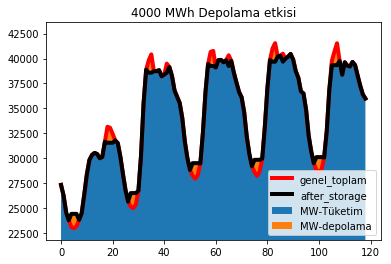

In [8]:
storage_graph(1,5,"4000 MWh Depolama etkisi")

### Tertiplenmiş yük eğrisindeki değişim

Elektrik sistemindeki en meşhur eğrilerden biri tertiplenmiş yük eğrisidir. Kısaca tüm sene boyunca tüm saatlerdeki tüketimi en yüksekten en düşüğe sıralayarak grafiklenir. 8760 saat için en yüksek ve en düşük talep saatlerini rahatça görebilmemizi sağlar

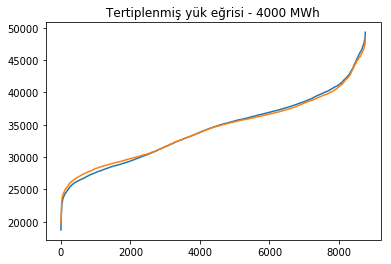

In [9]:
plot(prices.genel_toplam.sort_values().values)
plot(prices.after_storage.sort_values().values)
title("Tertiplenmiş yük eğrisi - 4000 MWh");

Tertiplenmiş yük eğrisinde büyük bir değişim görülmemektedir. Ama ortalama 800000 MWh tüketim olsa, günlük tüketimin sadece %0.5'i depolamaya konu olacağı için büyük bir etkisinin olmasını beklemiyorduk.

Fakat eğrinin iki ucuna bakmak faydalı olabilir.

Önce alt ucuna yani düşük talep dönemlerine bakalım. Bu dönemler baz yük santrallerini zorlayan dönemler.

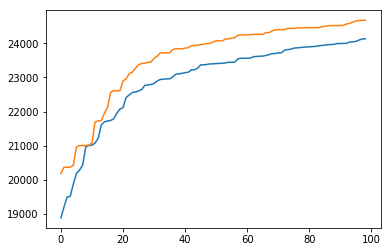

In [10]:
plot(prices.genel_toplam.sort_values().values[1:100])
plot(prices.after_storage.sort_values().values[1:100])

Bir de eğrinin en yüksek taleplerin görüldüğü dönemine bakalım. Yani en yüksek talebin olduğu 100 saat

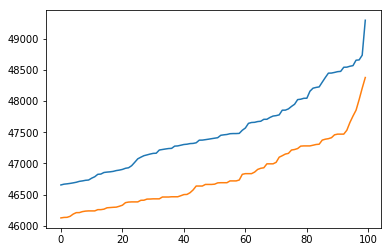

In [11]:
plot(prices.genel_toplam.sort_values().values[8660:])
plot(prices.after_storage.sort_values().values[8660:])

### Bazı istatistik veriler

Peki elektrik sistemimizdeki talep dağılımı bundan nasıl etkilendi? Bunun için de standart sapmaya bakmakta fayda var:

* genel_toplam'ın standart dağılımı bize depolamasız talebin değişkenliğini
* after_storage'ın standart dağılımı da bize depolamalı elektrik sistemin değişkenliğini verecektir.

In [12]:
prices.genel_toplam.std()

5284.741585746757

In [13]:
prices.after_storage.std()

4961.928488837606

Görüldüğü üzere sisteme 4000 MWh'lik bir depolama eklendiği zaman sistemin değişkenliği azalmaktadır.  
Bir de histogramlara bakalım.

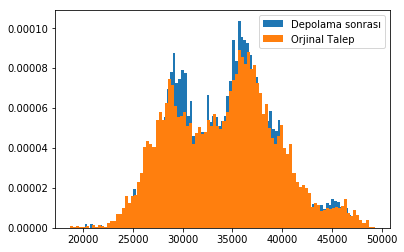

In [14]:
hist(prices.after_storage, bins=100, density=1,label="Depolama sonrası");
hist(prices.genel_toplam, bins=100, density=1,label="Orjinal Talep");
plt.legend(loc="best");

### Depolama hangi kaynakla daha iyi çalışıyor

Bu kısım tartışmalı da olsa, korelasyon katsayılarını görmekte yarar var. Hepimiz güneş ve depolama, elektrik sisteminin geleceği gibi düşünürken, veriler daha farklı bir şey söylüyor. Teknik bir tartışma olacağı için detaya girmeyeceğim. Ama muhtemelen depolama sistemdeki yenilenebilir seviyesine göre bir dengeleyici oyuncu olacaktır. Aynı zamanda baz yüke de katkı sağlayacaktır

In [15]:
prices[["dogalgaz","linyit","barajli","ithalkomur","akarsu","l_gunes","ruzgar","storage"]].corr().iloc[:,-1]

dogalgaz     -0.292437
linyit       -0.044975
barajli      -0.469158
ithalkomur   -0.189666
akarsu       -0.088841
l_gunes      -0.385809
ruzgar       -0.013945
storage       1.000000
Name: storage, dtype: float64

## Bir sonraki aşama

Farzedelim ki sistemde depolama çok ucuzladı ve 40000 MWh'lik bir depolama kapasitesi oldu. Bu 5000 MW* 8 Saat'e denk geldiği gibi, 10000MWh* 4 saat de olabilir. Bu hala Türkiye elektrik sisteminin günlük tüketiminin %5'inden fazlasına denk gelmemektedir.

Şimdi benzeticimizi ve tüm grafikleri bir de bu parametreler ile çalıştıralım. 365 gün için her 24 saatte 40000 MWh'in sisteme etkisini görelim.

In [16]:
for i in range(0,365):
    print(i,end=" ")
    sonuc=storage_player(prices.loc[(0+i*24):(23+i*24),'genel_toplam'],storage_amount=40000, storage_time=8)
    # çıkan değişkenleri prices'a ekle
    for j in range(0,24):
        prices.loc[j+i*24,"storage"]=sonuc.iloc[j,1]
        prices.loc[j+i*24,"after_storage"]=sonuc.iloc[j,2]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27


Örnek olarak yaz ayında bir haftalık tüketimde depolamanın etkisini görelim. Sonuçla mükemmel değil ama ekstra kötü de değil

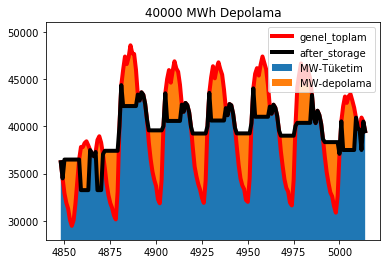

In [17]:
storage_graph(203,7,"40000 MWh Depolama")

Tertiplenmiş yük eğrimizde, ise %5 depolama ile tüm eğrinin biraz daha ortalamaya geldiğini görüyoruz. En yüksek talep saatlerinde neden sivrilik gitmedi diyebilirsiniz. İki sebebi olabilir:
* Algoritma doğru çalışmıyor olabilir
* Her halükarda yaz ve kış aylarında yüksek talep " o günün" dinamiklerini yansıtıyor. Yani ne kadar depolasanız da, mevsimler arası depolama yapılmıyorsa yüksek talep yüksek taleptir. Saatler arası kaydırma yeterli değişim sağlamaz

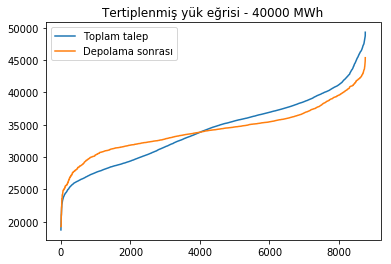

In [18]:
plot(prices.genel_toplam.sort_values().values, label="Toplam talep")
plot(prices.after_storage.sort_values().values, label="Depolama sonrası")
plt.legend(loc='best')
title("Tertiplenmiş yük eğrisi - 40000 MWh");

En yüksek talebin olduğu 100 saate bakalım

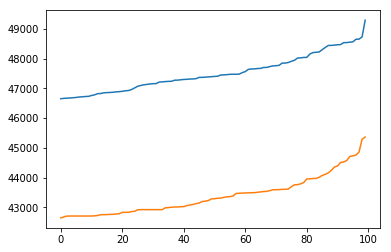

In [19]:
plot(prices.genel_toplam.sort_values().values[8660:])
plot(prices.after_storage.sort_values().values[8660:])

Bir de korelasyonların durumunu görelim

In [20]:
prices[["dogalgaz","linyit","barajli","ithalkomur","akarsu","l_gunes","ruzgar","storage"]].corr().iloc[:,-1]

dogalgaz     -0.413421
linyit       -0.061098
barajli      -0.648631
ithalkomur   -0.225924
akarsu       -0.123544
l_gunes      -0.578808
ruzgar       -0.025046
storage       1.000000
Name: storage, dtype: float64

Histogramlar ise depolamanın etkisi ile daha ortalamanın etrafında dağılan bir elektrik sistemi göstermektedir. Uçlar neredeyse kaybolmuş, tüm tüketim neredeyse saatlik olarak 30000 MW ile 40000 MW arasında dizilmektedir.

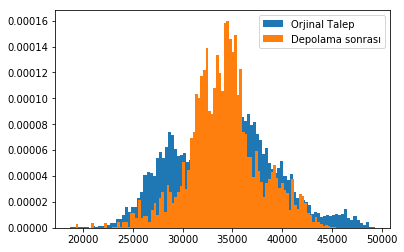

In [21]:
hist(prices.genel_toplam, bins=100, density=1,label="Orjinal Talep");
hist(prices.after_storage, bins=100, density=1,label="Depolama sonrası");

plt.legend(loc="best");

## Sonuç ve Teknik tartışma

Önce sorunlar:
* Algoritma çok stabil değil. Yani 1000 MW, 4 saat verseniz, olmayan kapasiteye elektriği şarj ediyor veya kullanıyor.
* Şarj ve deşarj süreleri birbirine karışmaktadır. Bunun sebebi akşam gerçekleşen düşük talep veya sabah erken gerçekleşen yüksek talepler

Depolama sisteminin Türkiye elektrik sistemini nasıl etkileyeceğini bilmiyoruz. Basit simulasyonlar da tüm etkileri göstermez. Ama ucuz bilgisayar gücü ile fikir veren benzetimler yapılabilir. 

Bu çalışma da bunlardan biridir.

Barış Sanlı, 31 Mart 2019, (barissanli2@gmail.com)

[barissanli.com](http://barissanli.com)